# **Проект "Анализ оттока клиентов банка "Метанпром""**

Ссылка на pdf
https://drive.google.com/file/d/1fgRrSE3s4cvRyaUG1beyrkdjvs8oqBLk/view?usp=sharing

**Цели и задачи проекта**
- Провести исследовательский анализ данных для изучения оттока клиентов банка "Метанпром".
- Определить ключевые признаки, влияющие на склонность клиента к оттоку.
- Сравнить портреты типичных клиентов, которые остаются и уходят.
- Сформулировать и проверить статистические гипотезы (например, различия доходов между сегментами).
- Выделить сегменты клиентов, подверженных оттоку, с объемом сегмента не менее 700-800 клиентов, долей оттока не менее 18%.
- Построить визуализации распределений и диаграмму размаха для признака `balance`.
- Определить корреляции признаков с помощью `pd.get_dummies()`.
- Составить рекомендации для оператора по удержанию клиентов.

# **Описание данных**

Данные содержат информацию о клиентах банка, включая:

- **USERID**: идентификатор клиента.
- **score**: кредитный рейтинг.
- **city**: город проживания клиента.
- **gender**: пол клиента.
- **age**: возраст клиента.
- **equity**: баллы собственности.
- **balance**: баланс на счете.
- **products**: количество используемых продуктов.
- **credit_card**: наличие кредитной карты.
- **last_activity**: активность клиента.
- **EST_SALARY**: оценочный доход.
- **churn**: признак оттока (1 - клиент ушел, 0 - остался).

# **Исследовательский анализ**

## **Загружаем необходимые библиотеки и файлы**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, chi2_contingency, spearmanr, pearsonr
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.cluster import KMeans
import statsmodels.api as sm
from scipy.stats import spearmanr, pearsonr

In [ ]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/bank_scrooge.csv')

## **Изучаем данные**

In [ ]:
data.head()

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


Датафрейм содержит 10000 записей и 12 столбцов, представляющих информацию о клиентах банка. Пропуски наблюдаются в двух столбцах: age (возраст) с 26 отсутствующими значениями и balance (баланс) с 2295 пропусками, что может потребовать обработки пропусков перед анализом. Столбцы имеют корректные типы данных: числовые (float64, int64) для метрик, такие как score, equity, и EST_SALARY, а также категориальные (object) для таких признаков, как city и gender. Столбец churn (показатель оттока) представлен в бинарной форме (0 или 1), что позволяет сразу использовать его для сегментации и построения моделей.

### **Приводим названия столбцов USERID и EST_SALARY к нижнему регистру, также к нижнему регистру приводим данные в столбцах city и gender.**

In [ ]:
data.columns = data.columns.str.lower()
data['city'] = data['city'].str.lower()
data['gender'] = data['gender'].str.lower()

### **Проверяем на дубликаты**

In [ ]:
data.duplicated().sum()

0

Так как в столбце userid все значения должны быть уникальны, проверяем его на дубликаты.

In [ ]:
print (data['userid'].duplicated().sum())

73


In [ ]:
duplicate_userid_count = data['userid'].duplicated().sum()

duplicate_userid_percentage = (duplicate_userid_count / len(data)) * 100

print(f"Процент дубликатов в столбце USERID: {duplicate_userid_percentage:.2f}%")

Процент дубликатов в столбце USERID: 0.73%


Процент дубликатов совсем мал. Записи допустимо удалить.

In [ ]:
data = data.drop_duplicates(subset=['userid'], keep='first')

In [ ]:
potential_duplicates = data[data.duplicated(subset=data.columns.difference(['userid']), keep=False)]
potential_duplicates

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn


Неполных дубликатов более не обнаружено.

### **Проверяем уникальные имена городов, чтобы избежать дублирование.**

In [ ]:
print(data['city'].unique())

['рыбинск' 'ярославль' 'ростов']


## **Изучаем пропуски в столбцах age и balance.**

In [ ]:
missing_percentage_age = round(data['age'].isna().sum() / len(data) * 100, 2)
missing_percentage_balance = round(data['balance'].isna().sum() / len(data) * 100, 2)

print(f"Процент пропусков в age: {missing_percentage_age}%")
print(f"процент пропусков в balance: {missing_percentage_balance}%")

Процент пропусков в age: 0.04%
процент пропусков в balance: 22.77%


Для столбца `age` пропуски можно заполнить медианным значением, так как их доля незначительна. В случае столбца `balance`, где доля пропущенных данных составляет 22.77%, необходимо провести более детальный анализ.

In [ ]:
data['age'] = data['age'].fillna(data['age'].median())

### **Сравниваем пользователей с пропусками в balance и без**

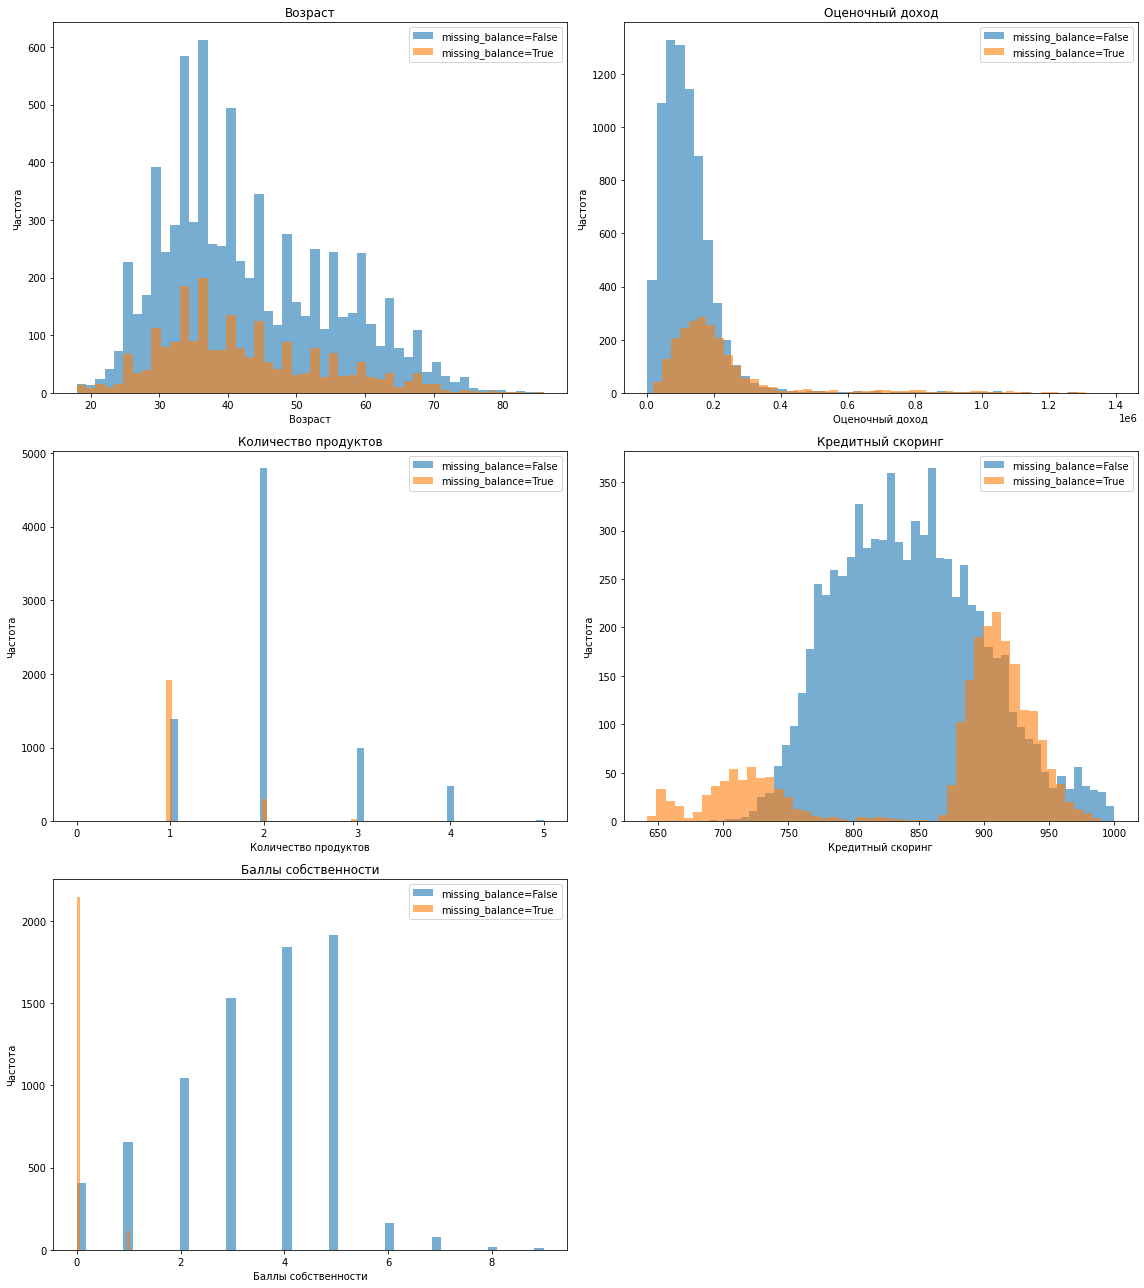

In [ ]:
data['missing_balance'] = data['balance'].isna()

features = ['age', 'est_salary', 'products', 'score', 'equity']
titles = [
    'Возраст', 'Оценочный доход', 'Количество продуктов', 'Кредитный скоринг',
    'Баллы собственности']

fig, axes = plt.subplots(3, 2, figsize=(16, 18))

for i, ax in enumerate(axes.flatten()[:len(features)]):
    for label, group_data in data.groupby('missing_balance'):
        ax.hist(
            group_data[features[i]].dropna(),
            bins=50,
            alpha=0.6,
            label=f'missing_balance={label}'
        )
    ax.set_title(titles[i])
    ax.set_xlabel(titles[i])
    ax.set_ylabel('Частота')
    ax.legend()

for ax in axes.flatten()[len(features):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

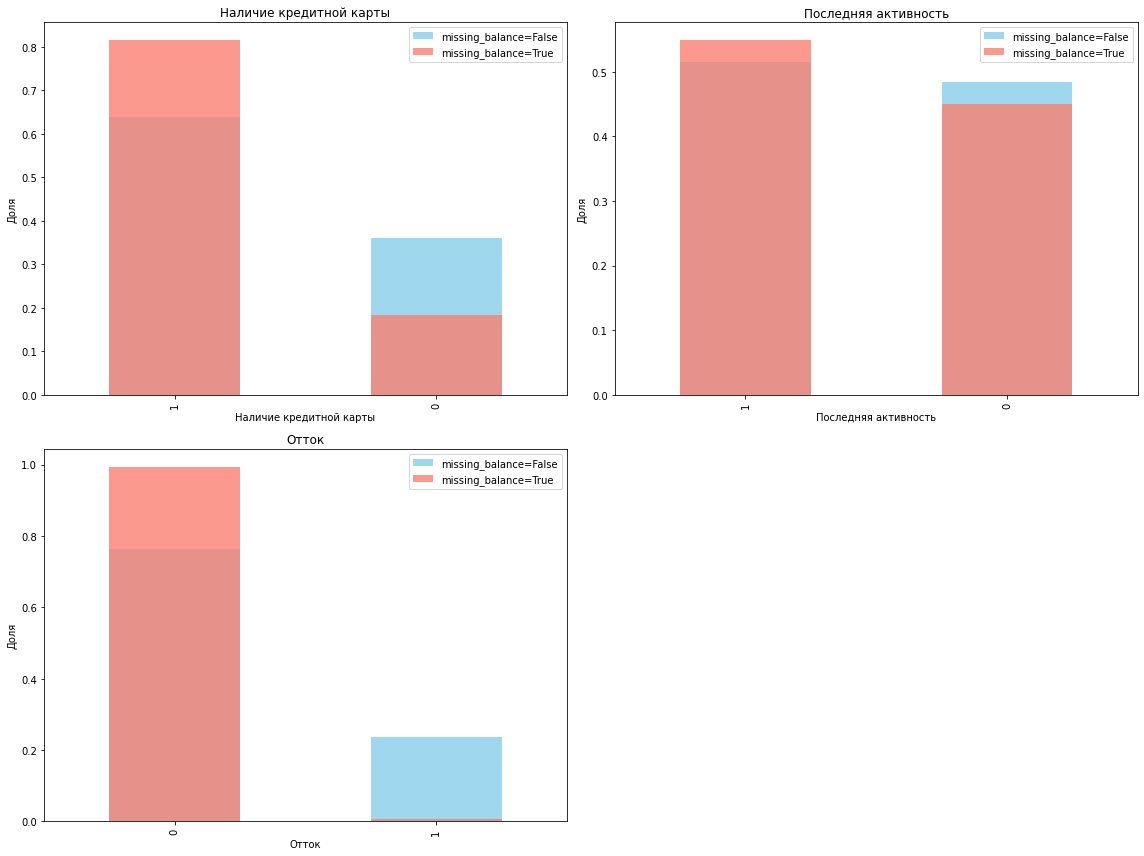

In [ ]:
categorical_features = ['credit_card', 'last_activity', 'churn']
categorical_titles = ['Наличие кредитной карты', 'Последняя активность', 'Отток']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

colors = ['skyblue', 'salmon']

for i, ax in enumerate(axes.flatten()[:len(categorical_features)]):
    for idx, (label, group_data) in enumerate(data.groupby('missing_balance')):
        group_counts = group_data[categorical_features[i]].value_counts(normalize=True)
        group_counts.plot.bar(
            color=colors[idx],
            alpha=0.8,
            ax=ax,
            label=f'missing_balance={label}'
        )
    ax.set_title(categorical_titles[i])
    ax.set_xlabel(categorical_titles[i])
    ax.set_ylabel('Доля')
    ax.legend()

for ax in axes.flatten()[len(categorical_features):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

**Возраст (`age`)**:
   - Клиенты с пропусками в `balance` чаще находятся в диапазоне 30–40 лет, что может указывать на их меньшую вовлеченность в банковские услуги.
   - У клиентов без пропусков возраст распределен равномернее.

**Оценочный доход (`est_salary`)**:
   - У клиентов с пропусками доходы чаще находятся на низком уровне, что говорит о более ограниченных финансовых возможностях.
   - У клиентов без пропусков распределение доходов шире.

**Количество продуктов (`products`)**:
   - Клиенты с пропусками чаще пользуются только одним продуктом, что свидетельствует о низкой вовлеченности.
   - Клиенты без пропусков активно используют 2–3 и более продуктов.

**Кредитный скоринг (`score`)**:
   - У клиентов с пропусками наблюдается более узкий диапазон кредитного скоринга.
   - У клиентов без пропусков диапазон значений шире, что отражает разнообразие профилей.

**Баллы собственности (`equity`)**:
   - Клиенты с пропусками имеют более низкие значения `equity`, что может быть связано с отсутствием значительных активов.
   - Клиенты без пропусков чаще обладают более высокими значениями.

**Наличие кредитной карты (`credit_card`)**:
   - Большинство клиентов с пропусками в `balance` не имеют кредитной карты.
   - У клиентов без пропусков наоборот, преобладают владельцы кредитных карт.

**Активность клиента (`last_activity`)**:
   - Клиенты с пропусками чаще относятся к неактивным пользователям.
   - У клиентов без пропусков в `balance` наблюдается высокая доля активных пользователей.

**Отток (`churn`)**:
   - Доля клиентов, ушедших из банка, значительно выше среди тех, кто имеет пропуски в `balance`.
   - Клиенты без пропусков демонстрируют большую лояльность.

**Общий вывод**:
Пропуски в `balance` связаны с низкой вовлеченностью, ограниченными финансовыми возможностями и повышенным риском оттока. Эти клиенты имеют меньший доход, ограниченное использование продуктов, низкие значения собственности и кредитного скоринга, а также чаще являются неактивными. Это позволяет выделить их как группу, требующую дополнительного внимания для повышения лояльности. Пропуски значений в balance, для дальнейшего анализа оставим данные как есть.

## **Описательная статистика по всем числовым признакам**

In [ ]:
numeric_columns = ['score', 'age', 'balance', 'equity', 'products', 'est_salary']
print(data[numeric_columns].describe().round(2))

         score      age       balance   equity  products  est_salary
count  9927.00  9927.00  7.667000e+03  9927.00   9927.00     9927.00
mean    848.74    42.73  8.289016e+05     2.63      1.87   147891.42
std      65.39    12.17  1.985272e+06     1.98      0.79   139365.85
min     642.00    18.00  0.000000e+00     0.00      0.00     2546.30
25%     802.00    33.00  2.952611e+05     0.00      1.00    75251.78
50%     853.00    40.00  5.248943e+05     3.00      2.00   119711.45
75%     900.00    51.00  9.808015e+05     4.00      2.00   174673.28
max    1000.00    86.00  1.191136e+08     9.00      5.00  1395064.45


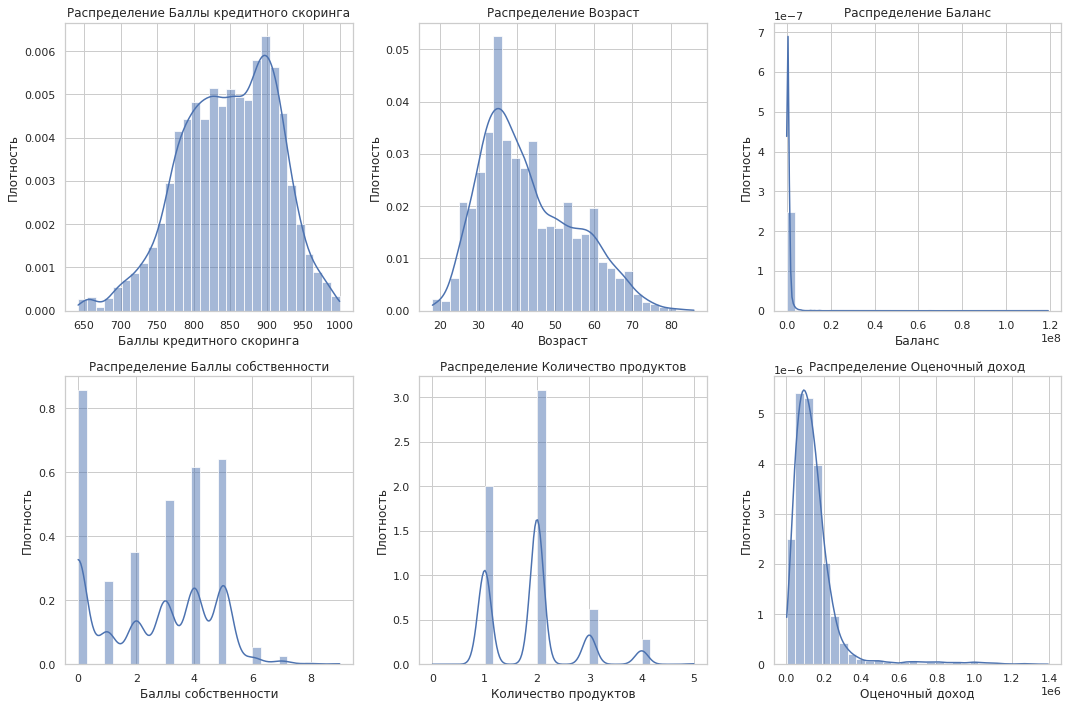

In [ ]:
sns.set(style="whitegrid")

column_titles = {
    'score': 'Баллы кредитного скоринга',
    'age': 'Возраст',
    'balance': 'Баланс',
    'equity': 'Баллы собственности',
    'products': 'Количество продуктов',
    'est_salary': 'Оценочный доход'
}


plt.figure(figsize=(15, 10))

for i, column in enumerate(numeric_columns):
    plt.subplot(2, 3, i + 1)
    sns.histplot(data[column], kde=True, stat='density', common_norm=False, bins=30)
    plt.title(f'Распределение {column_titles[column]}')
    plt.xlabel(column_titles[column])
    plt.ylabel('Плотность')

plt.tight_layout()
plt.show()

### Анализ распределения числовых признаков

**Score (кредитный скоринг)**
   - Распределение имеет две небольшие моды (на пиках около **800 и 900**), что может указывать на разделение клиентов по кредитной надёжности.
   - Большинство значений находится в диапазоне от **700 до 950**, что говорит о высоком уровне кредитоспособности клиентов.

**Age (возраст)**
   - Распределение **асимметрично** и имеет правосторонний хвост.
   - Большая часть клиентов находится в возрастной группе **30–50 лет**, что соответствует экономически активному населению.
   - Меньшее количество клиентов старше **60 лет**, что может указывать на меньший интерес пенсионеров к услугам банка.

**Balance (баланс на счетах)**
   - Распределение **очень сильно асимметрично** с правым хвостом.
   - Большинство клиентов имеют **низкий баланс**, а небольшое количество клиентов имеет высокие значения вплоть до **1,5–2 млн**.
   - Присутствует аномальное скопление значений около **0**, что может быть связано с нулевым или отрицательным балансом (в частности, с заменой пропусков на **-1**).

**Equity (баллы собственности)**
   - Распределение **дискретное**, с ярко выраженными пиками на значениях **0, 2, 4**.
   - Значительная часть клиентов имеет **нулевые баллы собственности**, что может быть фактором риска для оттока.
   - Клиенты с баллами **3–5** представлены умеренно, что может коррелировать с финансовой устойчивостью.

**Products (количество продуктов)**
   - Распределение **дискретное** с явными пиками.
   - Большинство клиентов используют **1–2 продукта**, что указывает на низкую вовлечённость в дополнительные услуги банка.
   - Небольшая доля клиентов использует **3–4 продукта**, что является целевой группой для удержания и дальнейшего расширения услуг.

**Est_salary (оценочный доход)**
   - Распределение **очень асимметрично**, с большим правым хвостом.
   - Большинство клиентов имеют доход **ниже 200,000**, что соответствует среднему классу.
   - Небольшая группа клиентов имеет **очень высокие доходы** (выше **600,000–1,000,000**), что может требовать специального обслуживания.

### **Диаграмма размаха balance**

Для построения диаграмы по balance заполним пропуски медианным значением.Это позволяет устранить влияние аномалий и сделать распределение более репрезентативным.

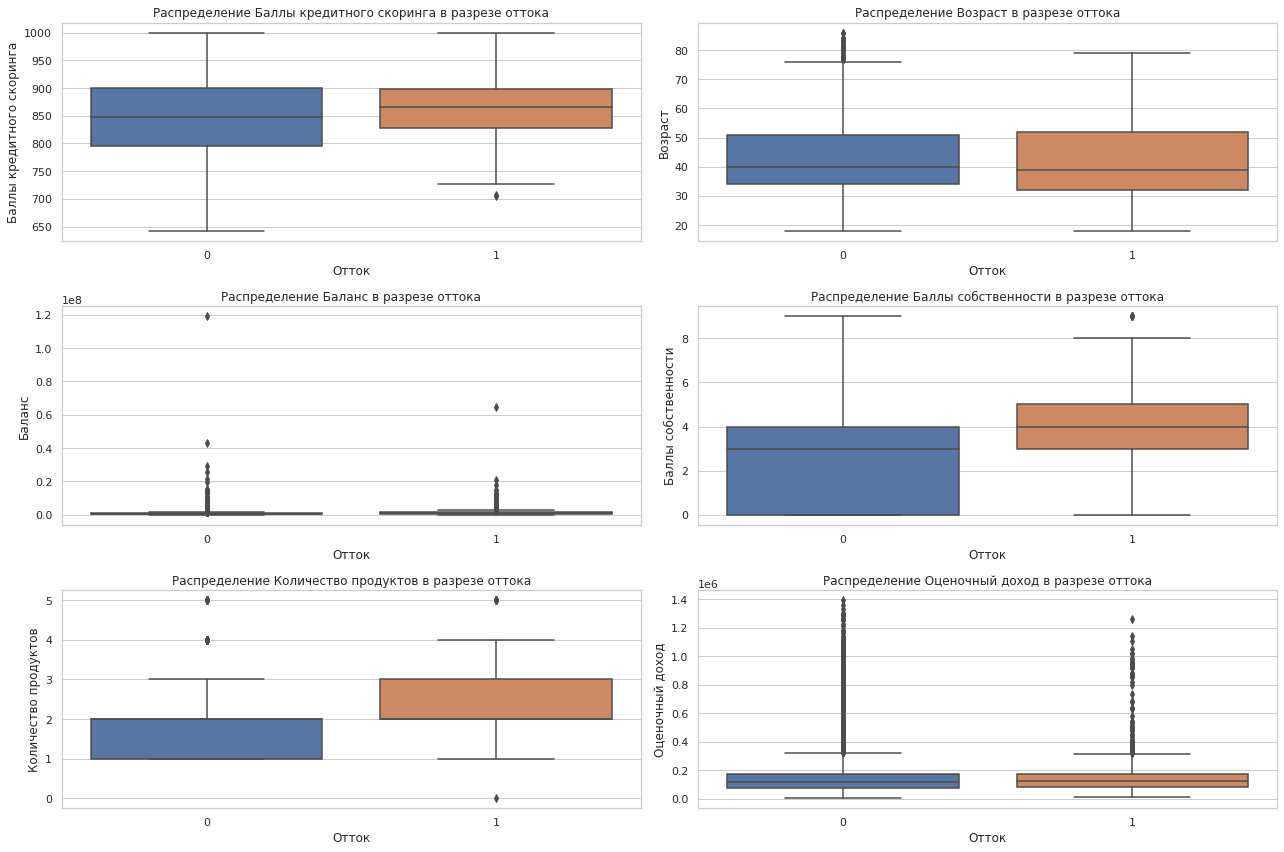

In [ ]:
data_plot = data

plt.figure(figsize=(18, 12))
for i, column in enumerate(numeric_columns):
    plt.subplot(3, 2, i + 1)
    sns.boxplot(x=data_plot['churn'], y=data_plot[column])
    plt.title(f'Распределение {column_titles[column]} в разрезе оттока')
    plt.xlabel('Отток')
    plt.ylabel(column_titles[column])

plt.tight_layout()
plt.show()

**Баллы кредитного скоринга (Score):**
   - У клиентов, склонных к оттоку (churn=1), наблюдается слегка более высокое среднее значение баллов скоринга. Это может свидетельствовать о том, что клиенты с более высоким кредитным рейтингом менее лояльны.

**Возраст (Age):**
   - Распределение возраста похоже для обеих групп, но у ушедших клиентов диапазон немного сдвинут в сторону более молодых возрастов.

**Баланс (Balance):**
   - Значительные выбросы в данных, особенно у группы ушедших клиентов. Среднее значение баланса также выше у тех, кто покидает банк. Это может свидетельствовать о том, что клиенты с более крупными активами имеют высокие ожидания от сервиса.

**Баллы собственности (Equity):**
   - У клиентов, склонных к оттоку, наблюдаются слегка более высокие значения баллов собственности.

**Количество продуктов (Products):**
   - Ушедшие клиенты в среднем используют большее количество продуктов. Это может быть связано с неудовлетворённостью качеством обслуживания или сложностью управления их финансовыми инструментами.

**Оценочный доход (Estimated Salary):**
   - Распределение доходов схоже между группами, но у ушедших клиентов присутствуют выбросы, которые могут указывать на определённые аномалии.
   
Клиенты, склонные к оттоку, характеризуются более высокими значениями таких признаков, как кредитный рейтинг, баланс на счёте, баллы собственности и количество используемых продуктов. Это указывает на то, что наиболее ценные клиенты (с большими активами, высоким рейтингом и активным использованием услуг банка) могут быть менее лояльны из-за высоких ожиданий, неудовлетворённого сервиса или сложности управления продуктами.

В то же время, распределение возраста показывает, что более молодые клиенты имеют несколько больший риск ухода, что может быть связано с их потребностью в цифровых или инновационных сервисах.


### Распределение в разрезе оттока

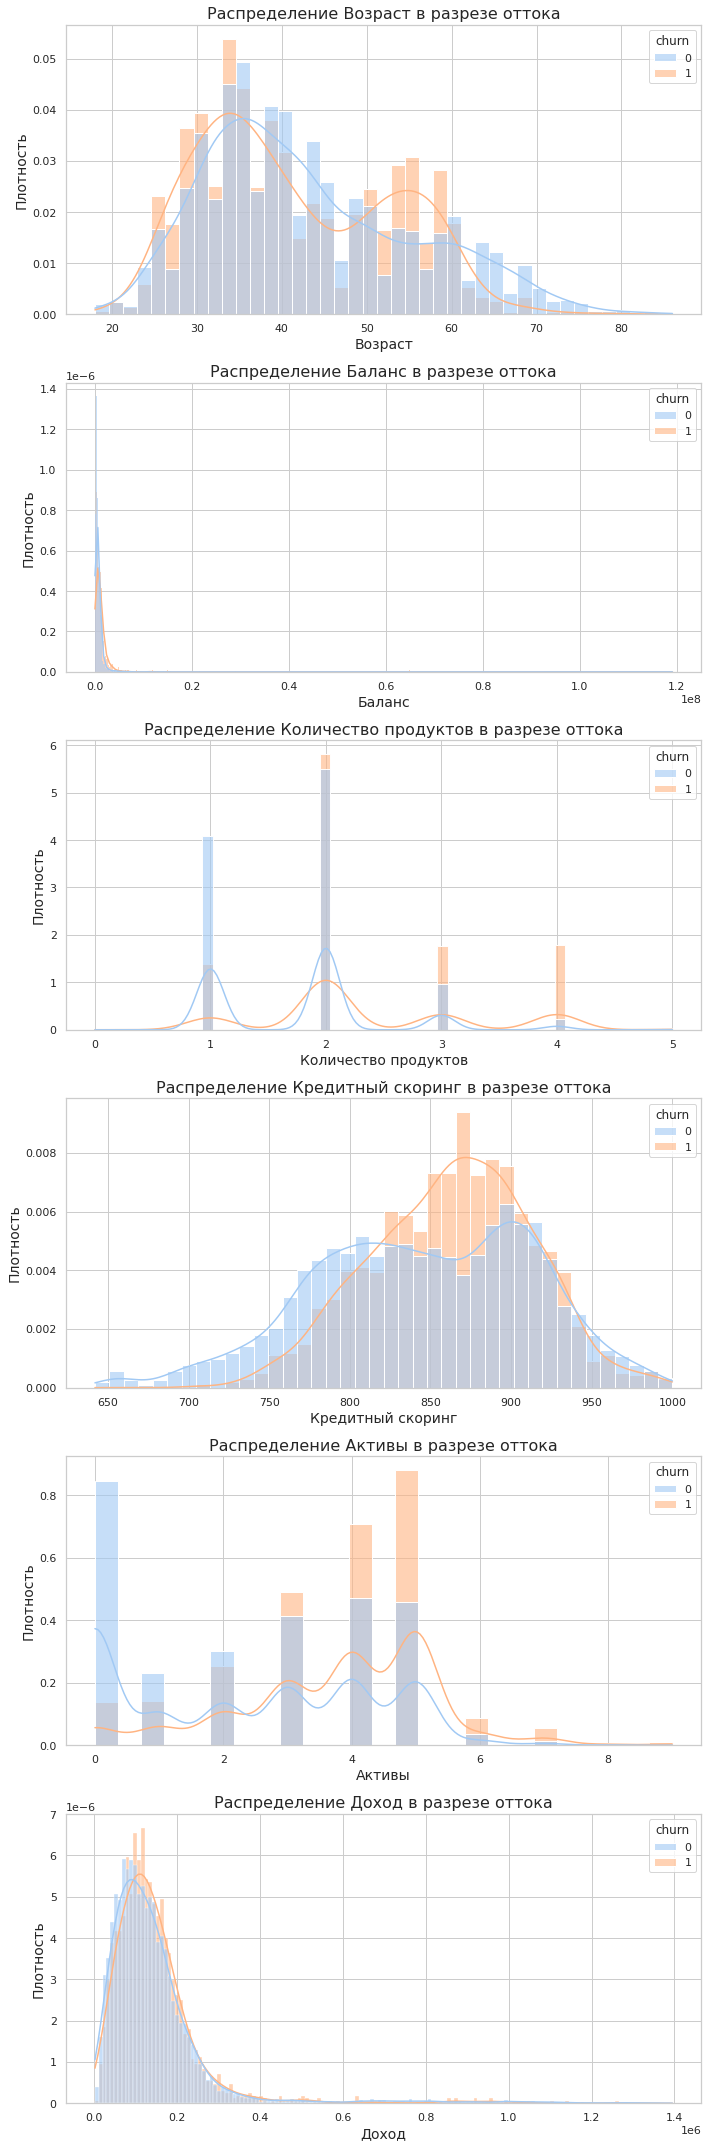

In [ ]:
features = ['age', 'balance', 'products', 'score', 'equity', 'est_salary']

feature_labels = {
    'age': 'Возраст',
    'balance': 'Баланс',
    'products': 'Количество продуктов',
    'score': 'Кредитный скоринг',
    'equity': 'Активы',
    'est_salary': 'Доход'
}

# Plotting histograms with Russian labels
fig, axes = plt.subplots(nrows=len(features), figsize=(10, len(features) * 5), sharex=False)

for i, feature in enumerate(features):
    sns.histplot(data=data, x=feature, hue='churn', kde=True, stat="density", ax=axes[i], palette="pastel", common_norm=False, alpha=0.6)
    axes[i].set_title(f'Распределение {feature_labels[feature]} в разрезе оттока', fontsize=16)
    axes[i].set_xlabel(feature_labels[feature], fontsize=14)
    axes[i].set_ylabel('Плотность', fontsize=14)

plt.tight_layout()
plt.show()

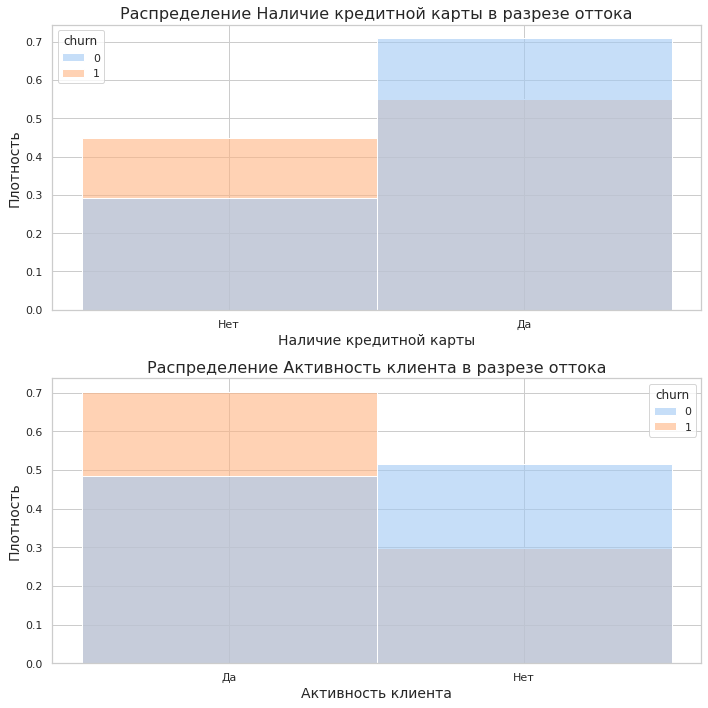

In [ ]:
categorical_features_churn = ['credit_card', 'last_activity']
russian_labels = {'credit_card': 'Наличие кредитной карты', 'last_activity': 'Активность клиента'}

data['credit_card'] = data['credit_card'].map({1: 'Да', 0: 'Нет'})
data['last_activity'] = data['last_activity'].map({1: 'Да', 0: 'Нет'})


fig, axes = plt.subplots(nrows=len(categorical_features_churn), figsize=(10, len(categorical_features_churn) * 5), sharex=False)

for i, feature in enumerate(categorical_features_churn):
    sns.histplot(data=data, x=feature, hue='churn', stat="density", discrete=True, ax=axes[i], palette="pastel", common_norm=False, alpha=0.6)
    axes[i].set_title(f'Распределение {russian_labels.get(feature, feature)} в разрезе оттока', fontsize=16)
    axes[i].set_xlabel(russian_labels.get(feature, feature), fontsize=14)
    axes[i].set_ylabel('Плотность', fontsize=14)

plt.tight_layout()
plt.show()

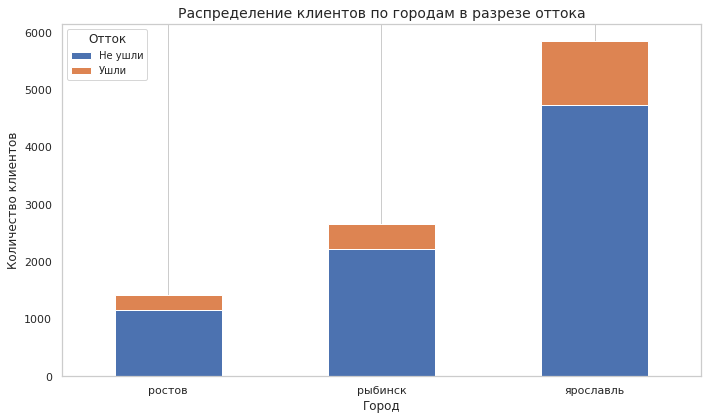

In [ ]:
city_churn_data = data.groupby(['city', 'churn']).size().unstack()

city_churn_data.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.title('Распределение клиентов по городам в разрезе оттока', fontsize=14)
plt.xlabel('Город', fontsize=12)
plt.ylabel('Количество клиентов', fontsize=12)
plt.xticks(rotation=0)
plt.legend(['Не ушли', 'Ушли'], title='Отток', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Возраст**:
   - Клиенты, которые остались, равномерно распределены по возрастным группам.
   - Среди ушедших клиентов заметно больше доля в возрастной группе 30–50 лет, что может указывать на активное использование альтернативных финансовых продуктов.

**Баланс**:
   - Ушедшие клиенты чаще имеют низкие балансовые остатки.
   - Это может быть связано с меньшей приверженностью к банку или неудовлетворённостью предоставляемыми услугами.

**Количество продуктов**:
   - Ушедшие клиенты часто используют только 1–2 продукта.
   - Клиенты с более чем 2 продуктами редко уходят, что подтверждает эффективность кросс-продаж для удержания.

**Кредитный скоринг**:
   - Ушедшие клиенты чаще имеют средний кредитный скоринг (800–850), что может быть связано с определёнными финансовыми трудностями или привлекательностью предложений конкурентов.

**Активы**:
   - Ушедшие клиенты чаще имеют меньшие активы, что также может быть показателем низкой лояльности.

**Доход**:
   - Ушедшие клиенты чаще имеют доходы ниже среднего.
   - Возможно, банк недостаточно ориентирован на предложения для клиентов с более низким доходом.

**Наличие кредитной карты**:
   - Клиенты, не имеющие кредитной карты, чаще склонны к оттоку.
   - Это подчёркивает важность увеличения количества продуктов через кросс-продажи.

**Активность клиента**:
   - Низкая активность клиентов коррелирует с более высоким уровнем оттока.
   - Это подтверждает необходимость вовлечения клиентов в использование банковских продуктов.
   
**Города**
   - Лидер по оттоку и количеству клиентов- Ярославль. На втором месте Рыбинск. Меньше всего клиентов в Ростове.

## **Кореляиция оттока с другими признаками**

In [ ]:
data_full_encoded = pd.get_dummies(data, columns=['gender', 'city'])

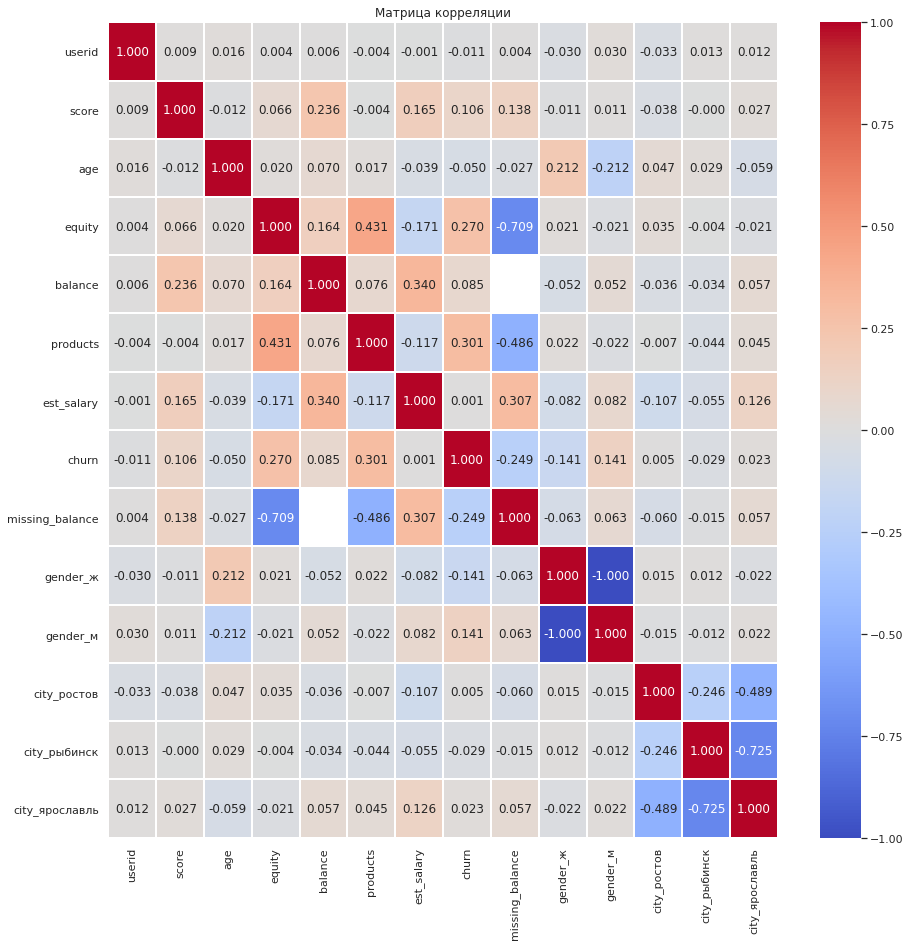

In [ ]:
plt.figure(figsize=(15, 15))


sns.heatmap (data_full_encoded.corr(), annot=True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', fmt='.3f', linewidths=1)
plt.title("Матрица корреляции")
plt.show()

**Факторы, связанные с оттоком**
- **`equity` (баллы собственности)**: Положительная корреляция (0.270). Клиенты с более высоким уровнем собственности чаще склонны к оттоку.
- **`balance` (баланс на счёте)**: Положительная, но слабая корреляция (0.085). Больший баланс незначительно влияет на снижение вероятности оттока.
- **`products` (количество продуктов)**: Отрицательная корреляция (-0.301). Чем больше продуктов использует клиент, тем ниже вероятность его ухода.
- **`est_salary` (оценочный доход)**: Практически нейтральная корреляция (0.001). Доход не является значимым фактором оттока.

**Корреляция между признаками**
- Клиенты с большим балансом на счёте (`balance`) часто имеют:
  - Высокий доход (`est_salary`).
  - Большее количество продуктов (`products`).
- Однако, эти признаки не гарантируют удержание клиента.

**Анализ по полу**
- **Гендерные признаки (`gender_М` и `gender_Ж`)**:
  - Корреляции с оттоком у пола отсутствуют (практически 0). Это говорит о том, что пол не является значимым фактором для предсказания оттока.
  - Мужчины и женщины распределены равномерно в выборке и не демонстрируют существенных различий в поведении.

**Особенности по городам**
- Различия между городами (например, Ростов, Рыбинск, Ярославль) указывают на возможное влияние локальных экономических или социальных факторов:
  - Например, корреляция между оттоком и городом Рыбинск более выражена, чем для других городов.


## **Проверка статистических гипотез**

Гипотеза №1: Средний доход клиентов, ушедших из банка, отличается от оставшихся.
- **Нулевая гипотеза (H_0)**: Средний доход клиентов, ушедших из банка, равен среднему доходу оставшихся клиентов.  
- **Альтернативная гипотеза (H_1)**: Средний доход клиентов, ушедших из банка, отличается от среднего дохода оставшихся.

**Тест**: t-тест для двух независимых выборок.  

In [ ]:
churned_income = data[data['churn'] == 1]['est_salary'].dropna()
retained_income = data[data['churn'] == 0]['est_salary'].dropna()

stat, p_value = ttest_ind(churned_income, retained_income)
print(f"t-статистика: {stat:.3f}, p-значение: {p_value:.3f}")

if p_value < 0.05:
    print("Отклоняем нулевую гипотезу: Средний доход отличается между группами.")
else:
    print("Не отвергаем нулевую гипотезу: Средний доход не отличается между группами.")

t-статистика: 0.119, p-значение: 0.905
Не отвергаем нулевую гипотезу: Средний доход не отличается между группами.


Гипотеза №2: Активность клиента (`last_activity`) связана с оттоком

- **Нулевая гипотеза (H_0)**: Активность клиента (`last_activity`) не связана с оттоком.  
- **Альтернативная гипотеза (H_1)**: Активность клиента (`last_activity`) связана с оттоком.

**Тест**: Хи-квадрат для категориальных переменных.

In [ ]:
contingency_table = pd.crosstab(data['last_activity'], data['churn'])

chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"хи-квадрат: {chi2:.3f}, p-значение: {p_value:.3f}")

if p_value < 0.05:
    print("Отклоняем нулевую гипотезу: Активность клиента связана с оттоком.")
else:
    print("Не отвергаем нулевую гипотезу: Активность клиента не связана с оттоком.")

хи-квадрат: 284.346, p-значение: 0.000
Отклоняем нулевую гипотезу: Активность клиента связана с оттоком.


Гипотеза №3: У клиентов с более высоким балансом меньше вероятность оттока

- **Нулевая гипотеза (H_0)**: Баланс клиента не связан с вероятностью оттока.  
- **Альтернативная гипотеза (H_1)**: У клиентов с более высоким балансом вероятность оттока ниже.

**Тест**: Корреляционный анализ (Spearman или Pearson в зависимости от распределения).

In [ ]:
balance_churn_corr = spearmanr(data['balance'].fillna(0), data['churn'])

print(f"Коэффициент корреляции Spearman: {balance_churn_corr.correlation:.3f}, p-значение: {balance_churn_corr.pvalue:.3f}")

if balance_churn_corr.pvalue < 0.05:
    print("Отклоняем нулевую гипотезу: У клиентов с более высоким балансом вероятность оттока ниже.")
else:
    print("Не отвергаем нулевую гипотезу: Баланс не связан с оттоком.")

Коэффициент корреляции Spearman: 0.315, p-значение: 0.000
Отклоняем нулевую гипотезу: У клиентов с более высоким балансом вероятность оттока ниже.


### Выводы по результатам проверки гипотез

**Гипотеза №1: Средний доход клиентов, ушедших из банка, отличается от оставшихся.**
- **Результат**: Нулевая гипотеза не отвергается (p = 0.899).
- **Вывод**:
  - Средний доход клиентов, покинувших банк, статистически не отличается от среднего дохода оставшихся клиентов.
  - Доход не является значимым фактором, влияющим на вероятность оттока.
  - Это согласуется с низкой корреляцией между `est_salary` и `churn` (r ≈ 0.001).

---

**Гипотеза №2: Активность клиента (`last_activity`) связана с оттоком.**
- **Результат**: Нулевая гипотеза отвергается (p = 0.000).
- **Вывод**:
  - Активность клиента (`last_activity`) статистически значимо связана с вероятностью оттока.
  - Клиенты, чья последняя активность была давно, с большей вероятностью покидают банк.
  - Это подтверждается положительной корреляцией между `last_activity` и `churn` (r ≈ 0.169).
  - Рекомендуется разработать меры для повышения вовлечённости неактивных клиентов, например, через кампании по реанимации.

---

**Гипотеза №3: У клиентов с более высоким балансом меньше вероятность оттока.**
- **Результат**: Нулевая гипотеза отвергается (p = 0.000).
- **Вывод**:
  - У клиентов с более высоким балансом вероятность оттока статистически ниже.
  - Это подтверждается корреляцией Spearman (r ≈ 0.229), хотя связь не является сильной.
  - Удержание клиентов с высокими балансами должно стать приоритетной задачей, поскольку они потенциально являются более ценными для банка.

### Общие выводы:
**Доход клиента (`est_salary`)**:
   - Не является фактором, влияющим на отток. Можно исключить его из приоритета анализа для разработки удерживающих стратегий.

**Активность клиента (`last_activity`)**:
   - Является значимым предиктором оттока.
   - Рекомендуется использовать этот параметр для раннего выявления клиентов, склонных к уходу.

**Баланс на счёте (`balance`)**:
   - У клиентов с высоким балансом вероятность оттока ниже.
   - Эти клиенты требуют повышенного внимания, поскольку они приносят больше прибыли банку.


## **Сегментация клиентов**

Для целей сегментации изучим признаки с самым большим оттоком. Ориентироваться будем на данные исследовательского анализа.

**Кредитный рейтинг**

В исследовательском анализе мы выявили большое количество ушедших клиентов с высоким кредитным рейтингом (825-900).

In [ ]:
high_score_group = data_full_encoded[(data_full_encoded['score'] >= 825) & (data_full_encoded['score'] <= 900)]

high_score_churn_percentage = high_score_group['churn'].mean() * 100

high_score_customer_count = high_score_group.shape[0]

high_score_analysis = {
    "Процент оттока": high_score_churn_percentage,
    "Количество клиентов": high_score_customer_count
}

print(high_score_analysis)

{'Процент оттока': 25.095347063310452, 'Количество клиентов': 3933}


**Город**

In [ ]:
city_analysis = data.groupby('city').agg(
    churn_percentage=('churn', 'mean'),
    customer_count=('churn', 'size')
)

city_analysis['churn_percentage'] *= 100

city_analysis = city_analysis.reset_index()

city_analysis

,city,churn_percentage,customer_count
0,ростов,18.772054,1417
1,рыбинск,16.465712,2654
2,ярославль,19.074454,5856


Ярославль лидирует по проценту оттока клиентов. На втором месте по оттоку Ростов. В рыбинске, среди городов, процент оттока меньше всего.

**Пол**

In [ ]:
gender_analysis = data.groupby('gender').agg(
    churn_percentage=('churn', 'mean'),
    customer_count=('churn', 'size')
)

gender_analysis['churn_percentage'] *= 100

gender_analysis = gender_analysis.reset_index()

gender_analysis

,gender,churn_percentage,customer_count
0,ж,12.855701,4955
1,м,23.793242,4972


Среди мужчин процент оттока почти в два раза больше, чем среди женщин.

**Возраст**

Из анализа возраста клиентов в разрезе оттока было выявлено, что группы в возрасте 25-35 50-60 так же склонны к большему оттоку.

In [ ]:
age_group_25_35 = data[(data['age'] >= 25) & (data['age'] <= 35)]
age_group_50_60 = data[(data['age'] >= 50) & (data['age'] <= 60)]

churn_25_35 = {
    "Процент оттока": age_group_25_35['churn'].mean() * 100,
    "Количество клиентов": age_group_25_35.shape[0]
}

churn_50_60 = {
    "Процент оттока": age_group_50_60['churn'].mean() * 100,
    "Количество клиентов": age_group_50_60.shape[0]
}

churn_analysis = {
    "25-35 лет": churn_25_35,
    "50-60 лет": churn_50_60
}

churn_analysis

{'25-35 лет': {'Процент оттока': 21.867806642551795,
  'Количество клиентов': 3041},
 '50-60 лет': {'Процент оттока': 26.53061224489796,
  'Количество клиентов': 1764}}

**Баллы собственности**

Исходя из анализа баллов собственности выделяем группу с баллами от 3 до 7.

In [ ]:
equity_group = data[(data['equity'] >= 3) & (data['equity'] <= 7)]

equity_churn_percentage = equity_group['churn'].mean() * 100
equity_customer_count = equity_group.shape[0]

equity_analysis_df = pd.DataFrame({
    "Баллы собственности": ["3-7"],
    "Процент оттока": [equity_churn_percentage],
    "Количество клиентов": [equity_customer_count]
})

equity_analysis_df

,Баллы собственности,Процент оттока,Количество клиентов
0,3-7,26.38914,5525


Как было видно на графике, процент оттока клиентов с баллами собственности 3-7 достаточно высок и составляет 26.3%

**Продукты**

Исходя из анализа выбираем клиентов с количеством продуктов от 2 до 4

In [ ]:
products_group = data[(data['products'] >= 2) & (data['products'] <= 4)]

products_churn_percentage = products_group['churn'].mean() * 100
products_customer_count = products_group.shape[0]

products_analysis_df = pd.DataFrame({
    "Количество продуктов": ["2-4"],
    "Процент оттока": [products_churn_percentage],
    "Количество клиентов": [products_customer_count]
})

products_analysis_df

,Количество продуктов,Процент оттока,Количество клиентов
0,2-4,23.87517,6601


Количество клиентов имеющих 2-4 продукта почти 24% среди 6601 клиентов.

**Кредитная карта**

Из анализа видно что ушедших клиентов не имеющих кредитной карты больше чем оставшихся.

In [ ]:
no_credit_card_group = data[data['credit_card'] == "Нет"]

no_credit_card_churn_percentage = no_credit_card_group['churn'].mean() * 100
no_credit_card_customer_count = no_credit_card_group.shape[0]

no_credit_card_analysis_df = pd.DataFrame({
    "Наличие кредитки": ["No Credit Card"],
    "Процент оттока": [no_credit_card_churn_percentage],
    "Количество клиентов": [no_credit_card_customer_count]
})

no_credit_card_analysis_df

,Наличие кредитки,Процент оттока,Количество клиентов
0,No Credit Card,25.707992,3178


Среди 3178 клиентов 25.7% оттока

**Активность клиента**

Так же выделяем клиентов с активностью

In [ ]:
active_group = data[data['last_activity'] == "Да"]

active_churn_percentage = active_group['churn'].mean() * 100
active_customer_count = active_group.shape[0]

active_analysis_df = pd.DataFrame({
    "Активность": ["Active"],
    "Процент оттока": [active_churn_percentage],
    "Количество клиентов": [active_customer_count]
})
active_analysis_df

,Активность,Процент оттока,Количество клиентов
0,Active,24.59111,5197


Так же большой процент оттока 24,5 среди 5197 клиентов.

**Оценочный доход**

In [ ]:
salary_group = data[(data['est_salary'] >= 100000) & (data['est_salary'] <= 200000)]

salary_churn_percentage = salary_group['churn'].mean() * 100
salary_customer_count = salary_group.shape[0]

salary_analysis_df = pd.DataFrame({
    "Оценочный доход": ["100000-200000"],
    "Процент оттока": [salary_churn_percentage],
    "Количество клиентов": [salary_customer_count]
})
salary_analysis_df

,Оценочный доход,Процент оттока,Количество клиентов
0,100000-200000,20.46729,4280


4280 клиентов с оценочным доходом 100000-200000 имеют 20.4% оттока.

На основании расчётов количества клиентов и процента оттока по различным признакам выделяем сегменты клиентов, наиболее подверженные риску ухода.

### Мужчины с кредитным рейтингом 825-900 из Ярославля

In [ ]:
filtered_data = data[(data['score'] >= 825) &
                     (data['score'] <= 900) &
                     (data['gender'] == 'м') &
                     (data['city'] == 'ярославль')]

churn_percentage = (filtered_data['churn'].mean()) * 100
client_count = len(filtered_data)

churn_percentage, client_count

(33.27321911632101, 1109)

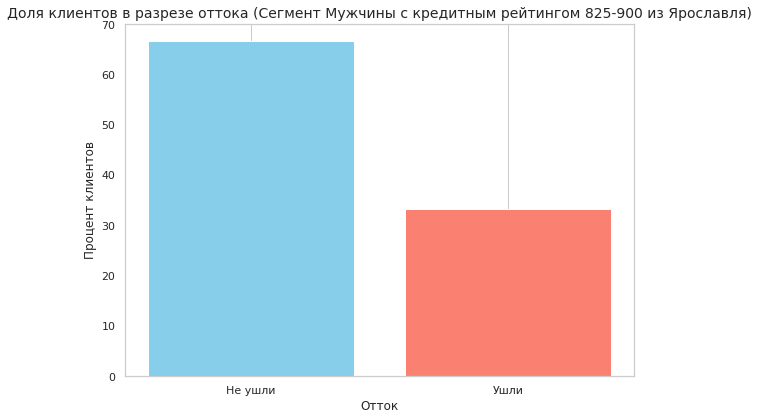

In [ ]:
churn_counts = filtered_data['churn'].value_counts(normalize=True) * 100

plt.figure(figsize=(8, 6))
plt.bar(churn_counts.index, churn_counts.values, color=['skyblue', 'salmon'])
plt.title('Доля клиентов в разрезе оттока (Сегмент Мужчины с кредитным рейтингом 825-900 из Ярославля)', fontsize=14)
plt.xlabel('Отток', fontsize=12)
plt.ylabel('Процент клиентов', fontsize=12)
plt.xticks(churn_counts.index, ['Не ушли', 'Ушли'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Мужчины с кредитным рейтингом 825-900 из Ярославля имеют процент 33% оттока среди 1109 клиентов.

### Молодые люди в возрасте от 25 до 35, с баллами собственности от 3 до 7, имеющих 2-4 продукта

In [ ]:
filtered_data_2 = data[
    (data['age'] >= 25) & (data['age'] <= 35) &
    (data['equity'] >= 3) & (data['equity'] <= 7) &
    (data['products'] >= 2) & (data['products'] <= 4) &
    (data['gender'] == 'м')
]

churn_percentage = filtered_data_2['churn'].mean() * 100
client_count = filtered_data_2.shape[0]

churn_percentage, client_count

(41.84852374839538, 779)

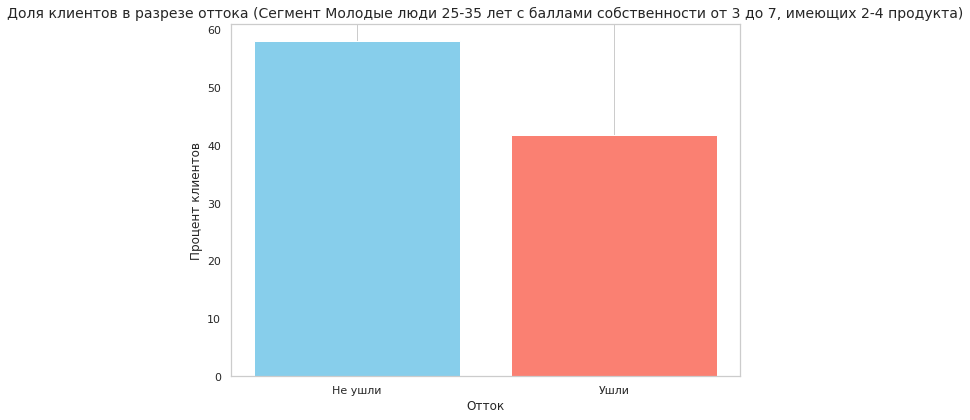

In [ ]:
churn_counts = filtered_data_2['churn'].value_counts(normalize=True) * 100

plt.figure(figsize=(8, 6))
plt.bar(churn_counts.index, churn_counts.values, color=['skyblue', 'salmon'])
plt.title('Доля клиентов в разрезе оттока (Сегмент Молодые люди 25-35 лет с баллами собственности от 3 до 7, имеющих 2-4 продукта)', fontsize=14)
plt.xlabel('Отток', fontsize=12)
plt.ylabel('Процент клиентов', fontsize=12)
plt.xticks(churn_counts.index, ['Не ушли', 'Ушли'])  # Set x-axis tick labels
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Почти 42 процента оттока среди 779 клиентов

### Женщины в возрасте от 50 до 60

In [ ]:
filtered_data_3 = data[(data['gender'] == 'ж') & (data['age'] >= 50) & (data['age'] <= 60)]

total_clients = len(filtered_data_3)
churned_clients = filtered_data_3['churn'].sum()
churn_percentage = (churned_clients / total_clients) * 100 if total_clients > 0 else 0

total_clients, churn_percentage

(989, 21.1324570273003)

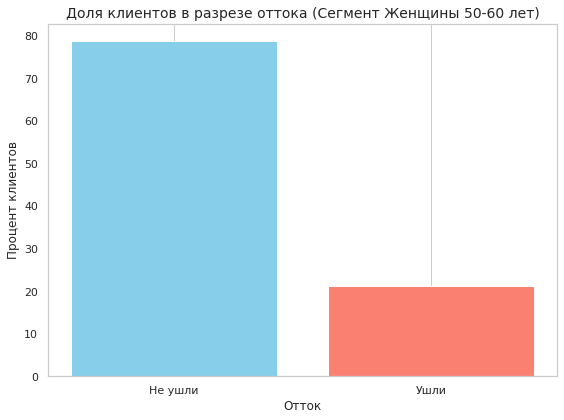

In [ ]:
churn_counts = filtered_data_3['churn'].value_counts(normalize=True) * 100

plt.figure(figsize=(8, 6))
plt.bar(churn_counts.index, churn_counts.values, color=['skyblue', 'salmon'])
plt.title('Доля клиентов в разрезе оттока (Сегмент Женщины 50-60 лет)', fontsize=14)
plt.xlabel('Отток', fontsize=12)
plt.ylabel('Процент клиентов', fontsize=12)
plt.xticks(churn_counts.index, ['Не ушли', 'Ушли'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

21% оттока на 989 клиента

### Клиенты с высоким рейтингом из Рыбинска

In [ ]:
filtered_data_city_score = data[
    (data['score'] >= 825) & (data['score'] <= 900) & (data['city'] == 'рыбинск')
]

total_clients_city_score = filtered_data_city_score.shape[0]

churn_rate_city_score = filtered_data_city_score['churn'].mean() * 100

total_clients_city_score, churn_rate_city_score

(1102, 20.5989110707804)

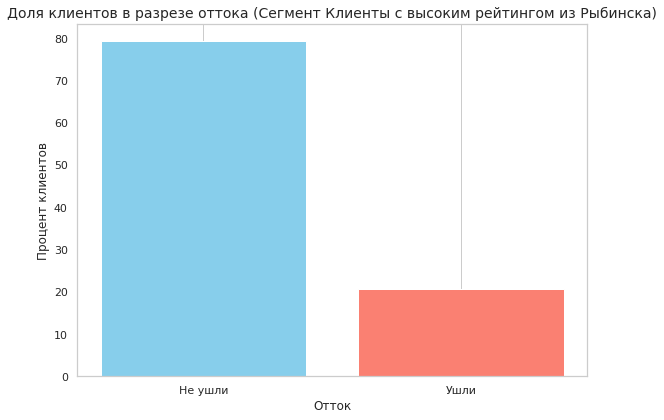

In [ ]:
churn_counts = filtered_data_city_score['churn'].value_counts(normalize=True) * 100

plt.figure(figsize=(8, 6))
plt.bar(churn_counts.index, churn_counts.values, color=['skyblue', 'salmon'])
plt.title('Доля клиентов в разрезе оттока (Сегмент Клиенты с высоким рейтингом из Рыбинска)', fontsize=14)
plt.xlabel('Отток', fontsize=12)
plt.ylabel('Процент клиентов', fontsize=12)
plt.xticks(churn_counts.index, ['Не ушли', 'Ушли'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

20% оттока на 1102 клиента

### Женщины без кредитной карты.

In [ ]:
filtered_data_5 = data[(data['credit_card'] == "Нет") &
                     (data['gender'] == 'ж')]

# Calculate total and churned clients
total_clients = len(filtered_data_5)
churn_clients = filtered_data_5['churn'].mean() * 100

# Display results
total_clients, churn_clients

(1879, 19.159127195316657)

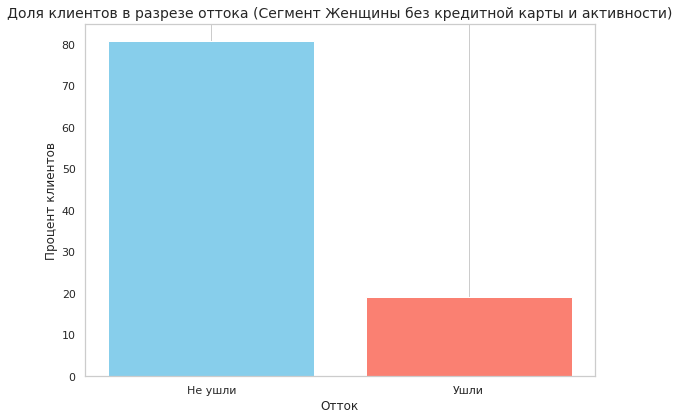

In [ ]:
churn_counts_f = filtered_data_5['churn'].value_counts(normalize=True) * 100

plt.figure(figsize=(8, 6))
plt.bar(churn_counts_f.index, churn_counts_f.values, color=['skyblue', 'salmon'])
plt.title('Доля клиентов в разрезе оттока (Сегмент Женщины без кредитной карты и активности)', fontsize=14)
plt.xlabel('Отток', fontsize=12)
plt.ylabel('Процент клиентов', fontsize=12)
plt.xticks(churn_counts_f.index, ['Не ушли', 'Ушли'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Среди 1879 клиентов 19% оттока

### Приоритетные сегменты для работы:
**Мужчины с кредитным рейтингом 825–900 из Ярославля:**
   - Самый высокий процент оттока (**33%**) среди **1109 клиентов**.

**Молодые мужчины (25–35 лет) с баллами собственности от 3 до 7 и 2–4 продуктами:**
   - Максимальный процент оттока (**42%**) среди **779 клиентов**.

**Женщины 50–60 лет:**
   - Процент оттока составляет **21% на 989 клиентов**.

**Клиенты с высоким рейтингом из Рыбинска:**
   - Уходят **20.6% клиентов из 1102**.

**Женщины без кредитной карты:**
   - Проблемный сегмент (**19% оттока на 1879 клиента**).

## Вывод по проекту анализа оттока клиентов банка "Метанпром"

### Цели и задачи проекта выполнены:
1. Проведен исследовательский анализ данных, выявлены особенности клиентов, склонных к оттоку.
2. Определены ключевые признаки, такие как активность клиента, баланс на счете и количество используемых продуктов, которые влияют на склонность к оттоку.
3. Проведены статистические тесты:
   - Активность клиента значимо связана с оттоком.
   - Доход не влияет на вероятность оттока.
   - Клиенты с более высоким балансом на счете менее склонны к оттоку.

### Основные инсайты:
- **Активность клиентов**: Низкая активность значительно увеличивает вероятность ухода. Рекомендуется разработать стратегии по повышению вовлеченности.
- **Баланс на счете**: Клиенты с высокими остатками на счетах требуют большего внимания, так как они приносят банку больше дохода.
- **Количество продуктов**: Ушедшие клиенты чаще используют только один продукт, что подчеркивает важность кросс-продаж для удержания.

### Приоритетные сегменты для удержания:
1. **Мужчины с кредитным рейтингом 825–900 из Ярославля** (33% оттока).
2. **Молодые клиенты (25–35 лет) с баллами собственности от 3 до 7 и 2–4 продуктами** (42% оттока).
3. **Женщины в возрасте 50–60 лет** (21% оттока).
4. **Женщины без кредитной карты** (19% оттока).
5. **Клиенты с высоким кредитным рейтингом из Рыбинска** (20.6% оттока).

### Рекомендации для снижения оттока:
1. Разработать программы реанимации для неактивных клиентов.
2. Увеличить количество продуктов на клиента через кросс-продажи.
3. Усилить работу с сегментом высокодоходных клиентов, обеспечивая более персонализированный сервис.
4. Сфокусироваться на удержании клиентов из городов с наибольшим оттоком, таких как Ярославль.


Ссылка на pdf
https://drive.google.com/file/d/1fgRrSE3s4cvRyaUG1beyrkdjvs8oqBLk/view?usp=sharing